In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input/all-dogs"))

# Any results you write to the current directory are saved as output.

['all-dogs']


**需要引入的包**

In [2]:
import torch

# 对图片绘制Bounding Box,并将框起来的主体(狗)进行裁剪
import os
from os.path import join
import torchvision
import xml.etree.ElementTree as ET

from torchvision import datasets,transforms
from torch.utils.data import DataLoader
from torch import nn
from torch import optim

from torchvision.utils import save_image

from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm # tqdm可创建一个进度条
import numpy as np
import pandas as pd

from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR,MultiStepLR

**设置随机种子**

In [ ]:
# seed = 23
# torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)

**Bounding Box** 根据Annotation中每张图片中的物体识别标注,将图片中的狗用边框框起来并裁剪出来,以方便之后判别器网络与生成。

**RAM Dataloader**将所有图片一次性先全部存入内存RAM中(img = torchvision.datasets.folder.default_loader(path)代码),因为在每次epoch中,batch图片会被迭代读取,迭代读取很耗费时间;然而如果将所有图片先一次性存入RAM中,再一个batch一个batch读取,则每一个epoch的训练速度会快很多

In [3]:
# All other datasets should subclass it. All subclasses should override __len__, 
# that provides the size of the dataset, and __getitem__, supporting integer indexing in range from 0 to len(self) exclusive.
from torch.utils.data import Dataset # An abstract class representing a Dataset.

class DogDataset(Dataset):
    def __init__(self, img_dir, annotations_dir, transform1=None, transform2=None):

        self.img_dir = img_dir
        self.img_names = os.listdir(img_dir)
        self.transform1 = transform1
        self.transform2 = transform2
        
        self.imgs = []
        for img_name in self.img_names:
            path = join(img_dir, img_name)
            img = torchvision.datasets.folder.default_loader(path)
    
            # Crop image
            annotation_basename = os.path.splitext(os.path.basename(path))[0]
            annotation_dirname = next(dirname for dirname in os.listdir(annotations_dir) if dirname.startswith(annotation_basename.split('_')[0]))
            annotation_filename = os.path.join(annotations_dir, annotation_dirname, annotation_basename)
            tree = ET.parse(annotation_filename)
            root = tree.getroot()
            objects = root.findall('object')
            
            for o in objects:
                bndbox = o.find('bndbox')
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                bbox = (xmin, ymin, xmax, ymax)
                img_ = img.crop(bbox)
                # Some crop's are black. if crop is black then don't crop
                if np.mean(img_) != 0:
                    img = img_

                if self.transform1 is not None:
                    img = self.transform1(img)

                self.imgs.append(img)

    def __getitem__(self, index):
        img = self.imgs[index]
        
        if self.transform2 is not None:
            img = self.transform2(img)
        
        return img

    def __len__(self):
        return len(self.imgs)

读取图片数据,同时利用一系列transforms操作处理读取的图片数据

In [4]:
batch_size = 32  # 设置每一个epoch里图片batch的batch size
image_size = 64  # 训练图片与生成图片的尺寸 64*64
nz = 128  # 将用于输入generator中的高斯白噪声张量的初始channel设为128(论文中为100)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 构建GPU设备


# 利用transforms对图片进行resize,中心裁剪,随机翻转等
# ColorJitter()函数可随机更改图像的亮度,对比度,饱和度与色调(brightness亮度,contrast对比度,saturation饱和度,hue色调),将这些参数设定为元组表示[min,max]值;
# RandomRotation()将图片随机旋转[-degrss,+degree]的角度;
# random_transforms = [
#     transforms.ColorJitter(),
#     transforms.RandomRotation(degrees=20)]
random_transforms = [transforms.ColorJitter(brightness=(1.0,1.25), contrast=(1.0,1.2), saturation=(1.0,1.2), hue=0),
                     transforms.RandomRotation(degrees=0)]

# Resize()函数将图片按照指定的尺寸进行长宽的resize,若只指定了一个数则resize为正方形,若指定一个tuple如(h,w),则resize成此尺寸
# CenterCrop()函数对图片进行中心切割，得到给定的尺寸,尺寸可为一个数或一个元组(h,w)
# RandomHorizontalFlip(p=0.5)按概率p对图片进行水平翻转,即p的概率翻转，p的概率不翻转
# RandomApply()可接受一个包含多个transforms的列表,并以概率p对图片执行这个transforms的列表中的所有transforms的操作
# ToTensor()函数把一个取值范围是[0,255]的PIL.Image或者shape为(H,W,C)的numpy.ndarray,转换成形状为[C,H,W],取值范围是[0,1.0]的torch.FloadTensor
# Normalize()函数给定均值:(R,G,B),方差:(R,G,B),将按照各个通道channel把Tensor正则化,即:Normalized_image=(image-mean)/std

# First preprocessing of data
transformer1 = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64)])

transformer2 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply(random_transforms,p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))
])

# ImageFolder()类在图片数据文件夹的根目录中读取所有图片;并对所有图片进行transform参数指定的一系列transforms操作;同时在读取每张图片时,
# 对每张图片执行loader参数指定的函数的操作(loader=doggo_loader)
# image_data = datasets.ImageFolder(root="../input/all-dogs",transform=transformer,loader=dog_loader)

# DogDataset将所有图片一次性先全部存入内存RAM中,再一个batch一个batch读取,则每一个epoch的训练速度会快很多
image_data = DogDataset(img_dir="../input/all-dogs/all-dogs/",annotations_dir="../input/annotation/Annotation/",transform1=transformer1,
                       transform2=transformer2)
# DataLoader()类为数据加载器。组合数据集和采样器，并在数据集上提供单进程或多进程迭代器。
# drop_last为True表示数据集大小不能被batch_size整除,设置为True后可删除最后一个不完整的batch,(一共20579张图片),num_workers=4表示开启四个线程
train_data_loader = DataLoader(dataset=image_data,batch_size=batch_size,shuffle=True,drop_last=False,num_workers=4)

# imgs,labels = next(iter(train_data_loader))

# train_data_loader中的每一次迭代的元素都分为两部分,一部分为batch data,即[B,C,H,W]的批图片张量数据; 
# 另一部分为batch data中每一张图片的label(此数据集中的labels全为0,但应该为1,所以在后面并不使用这个labels,而是自己创建labels,真图为1,假图为0)
# for i,batch_data in enumerate(train_data_loader,start=0):
#     data,label = batch_data
#     print("\nThe "+str(i)+"th "+"tensor\n",data)
#     if i == 5:
#         break
        
# imgs = imgs.permute(0,2,3,1)
# for i in range(15):
#     # print(imgs[i])
#     plt.imshow(imgs[i])
#     plt.show() # 利用plt.show()函数显示所有循环的图片

print("All images loaded in RAM")

All images loaded in RAM


In [5]:
# 对模型module中的子层(Conv与BatchNorm)进行权重与偏置的初始化
# All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        m.weight.data.normal_(0.0,0.02)  # 用均值为0,标准差为0.02的正态分布初始化网络权重
    elif classname.find("BatchNorm") != -1:
        m.weight.data.normal_(1.0,0.02) # 用均值为1,标准差为0.02的正态分布初始化网络权重
        m.bias.data.fill_(0) # 将偏置初始化为0
                

# 构建生成器Generator模型

In [6]:

# 输入Generator模型中的初始高斯白噪声张量的维度为(batch_size,in_channel,1,1)
# Generator模型主要由nn.Sequential()类中包含的一系列layers组成,每一个layer又可以看作一个子模型
# 此Generator模型中的nn.ConvTranspose2d()为2维的转置卷积操作(注意改视作操作可视作解卷积操作fractionally-strided convolutions，但并不是真正的解卷积操作),
# 当于借助nn.ConvTranspose2d()类中的步长参数stride来进行反卷积操作(解卷积),如输入为(batch_size,in_channel,H_in,W_in),
# 经过2维的转置卷积后为(batch_size,out_channel,H_out,W_out)

# 经过2维的转置卷积操作后,batch图片张量的:H_out=(H_in-1)stride[0]-2padding[0]+kernel_size[0]+output_padding[0]
# 经过2维的转置卷积操作后,batch图片张量的:W_out=(W_in-1)stride[1]-2padding[1]+kernel_size[1]+output_padding[1]

class G(nn.Module):
    def __init__(self,in_channel):
    # Used to inherit the torch.nn Module
        super(G,self).__init__()
        # 构建生成器中的主要模型,
        self.main = nn.Sequential(
            # 此时训练得到的batch图片维度为(batch_size,1024,4,4);接着进行批标准化BatchNormalization,批标准化的参数为此时batch图片的channel维度数
            nn.ConvTranspose2d(in_channel,1024,kernel_size=4,stride=1,padding=0,bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            
            # 此时训练得到的batch图片维度为(batch_size,512,8,8);接着进行批标准化BatchNormalization,批标准化的参数为此时batch图片的channel维度数
            nn.ConvTranspose2d(1024,512,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            
             # 此时训练得到的batch图片维度为(batch_size,256,16,16);接着进行批标准化BatchNormalization,批标准化的参数为此时batch图片的channel维度数
            nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            # 此时训练得到的batch图片维度为(batch_size,128,32,32);接着进行批标准化BatchNormalization,批标准化的参数为此时batch图片的channel维度数
            nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
             # 此时训练得到的batch图片维度为(batch_size,3,64,64)
            nn.ConvTranspose2d(128,3,kernel_size=4,stride=2,padding=1,bias=False),
            nn.Tanh()
        )
        
    def forward(self,input):
        output = self.main(input)
        return output
    
# 实例化Generator类，并将其放入GPU或CPU中
netG = G(in_channel=nz).to(device)
netG.apply(weights_init) # 用函数weights_init初始化生成器网络netG中的参数
        

G(
  (main): Sequential(
    (0): ConvTranspose2d(128, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

**构建判别器Discriminator模型**

In [7]:
#  输入判别器Discriminator模型中的初始高斯白噪声张量的维度为(batch_size,3,64,64)
# Discriminator模型主要由nn.Sequential()类中包含的一系列layers组成,每一个layer又可以看作一个子模型
# 此Discriminator模型中的nn.Conv2d()为2维的卷积操作,卷积操作可以增加图片的深度channel,与降低图片的H与W维度(降维)

# 经过2维的卷积操作后,batch图片张量的:H_out=floor((H_in+2padding[0]-dilation[0](kernerl_size[0]-1)-1)/(stride[0]+1))
# 经过2维的卷积操作后,batch图片张量的:W_out=floor((W_in+2padding[1]-dilation[1](kernerl_size[1]-1)-1)/(stride[1]+1))

class D(nn.Module):
    def __init__(self):
        super(D,self).__init__()
        # Used to inherit the torch.nn Module
        self.main = nn.Sequential(
            # 此时训练得到的batch图片维度为(batch_size,64,32,32);接着进行批标准化BatchNormalization,批标准化的参数为此时batch图片的channel维度数
            nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.2,inplace=True),
            
            # 此时训练得到的batch图片维度为(batch_size,128,16,16);接着进行批标准化BatchNormalization,批标准化的参数为此时batch图片的channel维度数
            nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.2,inplace=True),
            
            # 此时训练得到的batch图片维度为(batch_size,256,8,8);接着进行批标准化BatchNormalization,批标准化的参数为此时batch图片的channel维度数
            nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2,inplace=True),
            
            # 此时训练得到的batch图片维度为(batch_size,512,4,4);接着进行批标准化BatchNormalization,批标准化的参数为此时batch图片的channel维度数
            nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.2,inplace=True),
            
             # 此时训练得到的batch图片维度为(batch_size,1,1,1)
            nn.Conv2d(512,1,kernel_size=4,stride=1,padding=0,bias=False),
            nn.Sigmoid()
        )
        
    def forward(self,input):
        output = self.main(input)
        return output.view(-1,1) # 进行维度变换消减,从四维张量变为二维张量,相当于全为预测标签的一个二维张量[batch,pred_label]

    
# 实例化Discriminator类，并将其放入GPU或CPU中
netD = D().to(device)
netD.apply(weights_init) # 用函数weights_init初始化生成器网络netG中的参数

D(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace)
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False

**初始化超参数,构建判别器网络与生成器网络的Adam优化器**

![](http://)

In [8]:
# 计算 真实标签 与 output 之间的二进制交叉熵
criterion = nn.BCELoss()
# 生成一个固定的高斯白噪声张量,不用将其传入Variable()中用于计算梯度
fixed = torch.randn((64,nz,1,1),device=device)

# 设置判别器网络与生成器网络进行梯度上升优化的学习率,设置Adma优化器中beta_1的参数值为0.5(出自2016的DCGAN论文),初始化判别器网络与生成器网络的Adam优化器
lr_D = 0.0005
lr_G = 0.0005
beta1 = 0.5
optimizerD = optim.Adam(params=netD.parameters(),lr=lr_D,betas=(beta1,0.999))
optimizerG = optim.Adam(params=netG.parameters(),lr=lr_G,betas=(beta1,0.999))
# 函数torch.optim.lr_scheduler.StepLR(optimizer, step_size, gamma=0.1, last_epoch=-1)可以让模型优化器的学习率每step_size次的epoch后衰减(降低)一部分,
# 新的学习率为 lr = lr * gamma,即相当于将学习率乘以一个(0,1)之间的百分比进行衰减
# scheduler = MultiStepLR(optimizerD, gamma=0.6, milestones=[150,175])
# scheduler = ReduceLROnPlateau(optimizerD, gamma=0.9, milestones=[150,175])


# 此处,将真实标签设置为0.5(为了一定程度上缓解梯度弥散,以及提高生成器网络generator在反向传播时的参数优化效果以及图片生成效果)
real_label = 0.5
fake_label = 0

# 指定训练的epoch次数
epochs = 370

# 用于存储所有epoch下每一次迭代的判别器与生成器的损失函数值，用于之后绘制生成器与判别器损失函数变化曲线
D_losses = []
G_losses = []


def show_generator_img():
    noise = torch.randn((1,nz,1,1),device=device)
    # .to("cpu")将生成的假图片batch张量转移到cpu上,.clone()将张量复制一份,.detach()将张量之前的生成器generator计算图释放,.squeeze(0)删除张量dim=0上的维度(因为为1)
    gene_img = netG(noise).to("cpu").clone().detach().squeeze(0)
    gene_img = gene_img.permute(1,2,0) # 将假图片张量由(C,H,W)变为(H,W,C)即将channel移到dim=2上,以方便plt显示图片
    plt.imshow(gene_img)
    plt.show()

**结合WGAN的思路,为DCGAN加入gradient penality (将gradient penality加入判别器discriminator的loss function中),以进行结构与生成图片效果的优化**

In [9]:
# 要将每一次真实图片的batch张量的batch_size(batch_size_realData)传入函数中,因为最后一个batch的batch_size可能比规定的batch_size小,
# 因此获取每一次真实图片的batch张量的batch_size可以方便下方的张量alpha生成准确的第一维度batch_size值,这样alpha才能与这一次的真实图片的batch张量正确相加
def gradient_penality(netD,real_data,fake_data,batch_size_realData):
    # WCGAN中gradient penality公式中的lambda超参数值
    Lambda = 0.3
    
    # only constrait for Discriminator
    # fake_data.detach()在此将fake_data与生成器生成fake_data的计算图“脱钩”,在计算梯度时只会计算到判别器discriminator这里,
    #其之后的生成器generator不会再计算梯度
    fake_data = fake_data.detach()
    # read_data.detach()在此将read_data与其之前的计算图“脱钩”,当反向传播时梯度只会计算到read_data这里,不会往前继续计算
    real_data = real_data.detach()
    
    alpha = torch.rand((batch_size_realData,1,1,1),device=device)
    alpha = alpha.expand_as(real_data) # 将张量alpha的四个维度上的维度数扩展成与真实图片的batch张量上四个维度上的维度数一样
    
    # interpolates公式为alpha * real_data + ((1-alpha) * fake_data)
    interpolates = alpha * real_data + ((1-alpha) * fake_data)
    interpolates.requires_grad_()  # 将interpolates设置为可以计算梯度
    interpolates = interpolates.to(device) # 将interpolates放入设置好的device中计算(GPU中)
    
    disc_interpolates = netD(interpolates)
    
    # Computes and returns the sum of gradients of outputs w.r.t. the inputs.
    gradients = torch.autograd.grad(outputs=disc_interpolates,inputs=interpolates,grad_outputs=torch.ones_like(disc_interpolates),
                                    create_graph=True,retain_graph=True,only_inputs=True)
    # 此时返回的gradients求和为一个只包含一个张量的元组,必须将梯度求和张量从元祖中取出,才能进行之后的计算
    gradients = gradients[0]
    
    # gp为梯度和gradients(sum of gradients)的二范数再减一的平方的期望值,再乘以系数Lambda
    gp = ((gradients.norm(2,dim=1) - 1) **2 ).mean() * Lambda
    
    return gp

**开始进行训练迭代,Starting Training Loop**

[1/370][345/692] Loss_D: 1.1861 Loss_G: 1.5072 D(x): 0.3545 D(G(z)): 0.0726 / 0.0713
[1/370][691/692] Loss_D: 1.4565 Loss_G: 1.0386 D(x): 0.2342 D(G(z)): 0.1981 / 0.1531



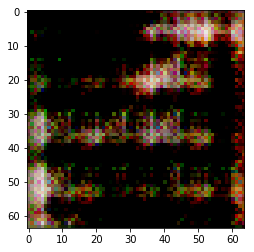

[2/370][345/692] Loss_D: 1.4558 Loss_G: 1.0636 D(x): 0.2469 D(G(z)): 0.2015 / 0.1515
[2/370][691/692] Loss_D: 1.3342 Loss_G: 1.2279 D(x): 0.3020 D(G(z)): 0.1014 / 0.1100



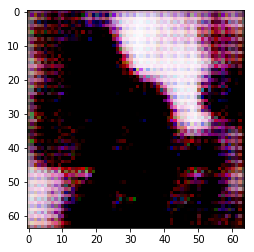

[3/370][345/692] Loss_D: 1.4578 Loss_G: 1.0533 D(x): 0.2145 D(G(z)): 0.1514 / 0.1599
[3/370][691/692] Loss_D: 1.3925 Loss_G: 1.2135 D(x): 0.3345 D(G(z)): 0.2491 / 0.1113



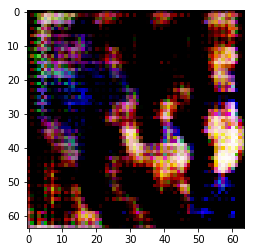

[4/370][345/692] Loss_D: 1.6151 Loss_G: 1.3978 D(x): 0.4510 D(G(z)): 0.4347 / 0.0750
[4/370][691/692] Loss_D: 1.3530 Loss_G: 1.0411 D(x): 0.3004 D(G(z)): 0.1880 / 0.1613



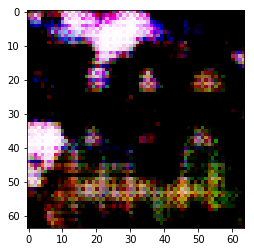

[5/370][345/692] Loss_D: 1.4357 Loss_G: 1.1308 D(x): 0.2395 D(G(z)): 0.2042 / 0.1352
[5/370][691/692] Loss_D: 1.3085 Loss_G: 1.5731 D(x): 0.4352 D(G(z)): 0.2177 / 0.0485



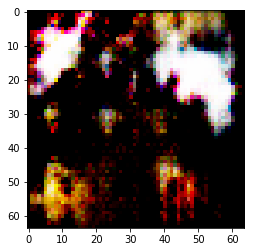

[6/370][345/692] Loss_D: 1.5972 Loss_G: 1.1863 D(x): 0.3640 D(G(z)): 0.3901 / 0.1226
[6/370][691/692] Loss_D: 1.6661 Loss_G: 0.9343 D(x): 0.1544 D(G(z)): 0.2353 / 0.2102



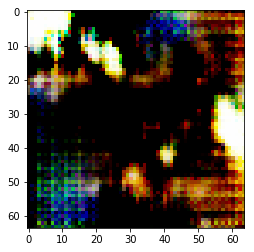

In [ ]:

for epoch in range(epochs):
    # 在每个epoch中,每一次迭代读取一个图片batch进行生成器网络与判别器网络的训练,当图片数据集中的所有batch都迭代过一遍用于训练网络之后,
    # 此epoch结束,进入下一个epoch重复此过程，tqdm可创建一个进度条
    
    for i,batch_data in tqdm(enumerate(train_data_loader),total=len(train_data_loader)):
        # train_data_loader中的每一次迭代的元素都分为两部分,一部分为batch data,即[B,C,H,W]的批图片张量数据; 
        # 另一部分为batch data中每一张图片的label(此数据集中的labels全为0,但应该为1,所以在后面并不使用这个labels,而是自己创建labels,真图为1,假图为0)
#         batch_data,_ = batch_data
        
        # 参考:https://zhuanlan.zhihu.com/p/43843694?utm_source=wechat_session&utm_medium=social&utm_oi=619857715934138368
        ### 训练判别器网络, Update D network: maximize  real_label*log(D(x)) + (1-fake_label)*log(1 - D(G(z))) ###
        
        # 在利用反向传播更新判别器网络的参数时,应将判别器网络的梯度清零,防止上一次迭代计算的判别器网络梯度叠加到这一次迭代计算的梯度上
        netD.zero_grad()
        real_data = batch_data.to(device) # 将真实图片数据的batch张量放入设定device中(同时将其变为了可求梯度的Variable)
        batch_size_realData = real_data.shape[0] # 获取当前迭代的批图片batch的张数,以方便之后生成的labels与noise张量的batch_size与当前batch图片的张数对应
        # 创建标签张量,此事给次张量赋值为real_label的值,之后可通过调用label.fill_(fake_label)来给其赋fake_label的值(放入device也将其变为了可求梯度的Variable)
        labels = torch.full((batch_size_realData,1),real_label,device=device)
        
        # 利用真实图片的batch张量来训练判别器网络
        output_real_D = netD(real_data) # 将真实图片batch张量输入判别器网络中输出结果
#         print("output_real_D",output_real_D.shape,"labels",labels.shape,"real_data",real_data.shape)
        errD_real = criterion(output_real_D,labels)
        # 将判别器判真实图片的损失函数进行反向传播计算现有计算图上的所有梯度(仅计算了判别式梯度,前向计算图默认仅计算一次反向传播梯度,其在反向传播后即被释放)
        errD_real.backward() 
        D_x = output_real_D.mean().item() # 此为求D(x)/batch_size的值,mean()为求均值,item()为将此张量中的值转换为标准的python数值
        
        # 利用生成器生成的假图片batch张量来训练判别器网络
        noise = torch.randn((batch_size_realData,nz,1,1),device=device) # 生成要输入生成器网络的高斯白噪声(放入device也将其变为了可求梯度的Variable)
        fake_data = netG(noise) # 将高斯白噪声输入生成器网络,生成假图片batch张量
        labels.fill_(fake_label) # 调用label.fill_(fake_label)来给其赋fake_label的值
        # fake_data.detach()在此将fake_data与生成器生成fake_data的计算图“脱钩”,在计算梯度时只会计算到判别器discriminator这里,
        #其之后的生成器generator不会再计算梯度
        output_fake_D = netD(fake_data.detach()) 
        errD_fake = criterion(output_fake_D,labels)
        # 将判别器判别假图片的损失函数进行反向传播计算现有计算图上的所有梯度(再次仅计算了判别式梯度且与之前计算的梯度相加,前向计算图默认仅计算一次反向传播梯度,其在反向传播后即被释放)
        errD_fake.backward() 
        
        gp = gradient_penality(netD,real_data,fake_data,batch_size_realData)
        gp.backward()
        
        D_G_z1 = output_fake_D.mean().item()
        errD = errD_real + errD_fake + gp
        optimizerD.step() # 根据判别器的所有损失函数反向传播计算的梯度,更新判别器网络dscriminator的所有参数
        
        
        # 参考:https://zhuanlan.zhihu.com/p/43843694?utm_source=wechat_session&utm_medium=social&utm_oi=619857715934138368
        ### 训练生成器网络, Update G network: maximize real_label*log(D(G(z))) ###
        
        netG.zero_grad() # 将生成器网络的梯度清零,防止上一次迭代计算的生成器网络梯度叠加到这一次迭代计算的梯度上
        labels.fill_(real_label) # 在训练生成器时,要将标签全部变为真实标签real_label,这么做才能将生成器损失函数变为real_label*log(D(G(z)))
        # 此时要将假图片张量传入判别器网络中重新计算分类结果,因为之前在此处将fake_data.detach()了(生成器网络的计算图被释放了),重新计算是为了让生成器损失函数在
        # 反向传播时能够计算到生成器网络的梯度,之后生成器网络才能够利用反向传播计算的梯度来更新其参数.此时判别器网络虽然也计算了梯度,但是不用这些梯度来更新判别器网络
        output_fake_D = netD(fake_data)
        errG = criterion(output_fake_D,labels)
        # 将生成器的损失函数进行反向传播计算现有计算图上的所有梯度(先计算了判别器梯度再计算了生成器梯度,但只更新生成器参数,前向计算图默认仅计算一次反向传播梯度,其在反向传播后即被释放)
        errG.backward() 
        
        D_G_z2 =  output_fake_D.mean().item()
        optimizerG.step()  # 根据生成器损失函数反向传播计算的梯度,更新生成器网络generator的所有参数
        
        # 用于存储所有epoch下每一次迭代的判别器与生成器的损失函数值，用于之后绘制生成器与判别器损失函数变化曲线
        D_losses.append(errD.item())
        G_losses.append(errG.item())
        
        # 若当前迭代次数加1,与总batch数除以2得的整数相除所得的余数为0,则输出当前epoch、总epochs、当前迭代数与总迭代数、当前判别器的总损失函数值,
        # 当前生成器的损失函数值、real_label*log(D(x))、(1-fake_label)*log(1 - D(G(z)))与real_label*log(D(G(z)))
        if (i+1) % (len(train_data_loader)//2) == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f' % 
                  (epoch+1,epochs,i,len(train_data_loader),errD.item(),errG.item(),D_x,D_G_z1,D_G_z2))
    
    # 传入判别器的总loss,之后scheduler按照step_size的epoch进行判别器学习率衰减
    # scheduler.step()
    # print(optimizerD.param_groups[0]["lr"])# 输出当前判别器优化器的学习率
    #if (epoch + 1)%10 == 0:
    #    print("Epoch completed:",epoch)
    
    # 当一个epoch迭代完之后,调用生成器网络netG生成一张假图片并显示,查看生成器效果
    show_generator_img()

In [ ]:
# a = torch.randn((64,64,3))
# print(a)
# plt.imshow(a)
# plt.show()

In [ ]:
# def show_generator_img():
#     noise = torch.randn((1,nz,1,1),device=device)
#     # .to("cpu")将生成的假图片batch张量转移到cpu上,.clone()将张量复制一份,.detach()将张量之前的生成器generator计算图释放,.squeeze(0)删除张量dim=0上的维度(因为为1)
#     gene_img = netG(noise).to("cpu").clone().detach().squeeze(0)
#     gene_img = gene_img.permute(1,2,0) # 将假图片张量由(C,H,W)变为(H,W,C)即将channel移到dim=2上,以方便plt显示图片
#     plt.imshow(gene_img)
#     plt.show()
# show_generator_img()

**利用训练好的生成器网络generator, 将batch_size为10000的噪声, 训练成为10000张基于生成器网络生成的小狗图片**

In [ ]:
# 将所有用训练好的生成器网络generator,基于噪声,生成出的10000张基于生成器网络生成的小狗图片存与output_images,若无此目录,则创建
if not os.path.exists("../output_images"):
    os.mkdir("../output_images")
    
per_gen_batch_size = 50 # 每次用训练好的生成器网络generator将50个噪声生成为小狗图片
gen_images = 10000 # 总共要用训练好的生成器网络生成10000张小狗图片

# 每次用训练好的生成器网络训练50张小狗图片,一共训练 gen_images/per_gen_batch_size 次
for i_batch in range(0, gen_images, per_gen_batch_size):
    # nz为噪声的初始通道数,之前定义过,为128(论文中为100),生成batch为50的噪声,用于生成器生成小狗图片
    gen_noise = torch.randn((per_gen_batch_size,nz,1,1), device = device)
    gen_images = (netG(gen_noise) + 1.)/2. 
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1) # 将由噪声生成的小狗图片batch张量中的通道维从第二维度变换到最后一维
    # 循环由噪声生成的小狗图片batch张量中的每张图片,一张张存储, it un-normalizes the images and increases the LB((gen_images[i_image,:,:,:] + 1.)/2. ) 
    for i_image in range(gen_images.shape[0]):
        save_image( gen_images[i_image,:,:,:] ,os.path.join("../output_images",f"image_{i_batch+i_image:05d}.png"))

# 将../output_images路径下存储着所有生成器网络基于噪声生成的图片的output_images文件夹,打包成zip压缩包格式,命名为images
import shutil
shutil.make_archive("images","zip","../output_images")

        

**将训练好的判别器网络与生成器网络存储起来,以便下次载入使用**

In [ ]:
# 将训练好的判别器网络与生成器网络存储起来,以便下次载入使用
torch.save(netD.state_dict(),"discriminator.pth")
torch.save(netG.state_dict(),"generator.pth")